In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [2]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import threading
%matplotlib inline

In [3]:
import pynq

rails = pynq.get_rails()
recorder = pynq.DataRecorder(rails['12V'].power)

In [4]:
def prepare_prediction(pred):
    mask = np.argmax(pred, axis=-1)
    mask = mask.astype('uint8')
    return mask

In [5]:
overlay.load_model("4M.xmodel")

In [6]:
image_folder = 'images'
original_images = [i for i in os.listdir(image_folder) if i.endswith("npy")]
total_images = len(original_images)
print(total_images)

500


In [7]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

In [8]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

In [9]:
def run(image_index, save = False):
    preprocessed = np.load("images/" + original_images[image_index])
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    if save:
        pred = output_data[0]
        pred = prepare_prediction(pred)
        np.save('predictions/'+original_images[image_index], pred)

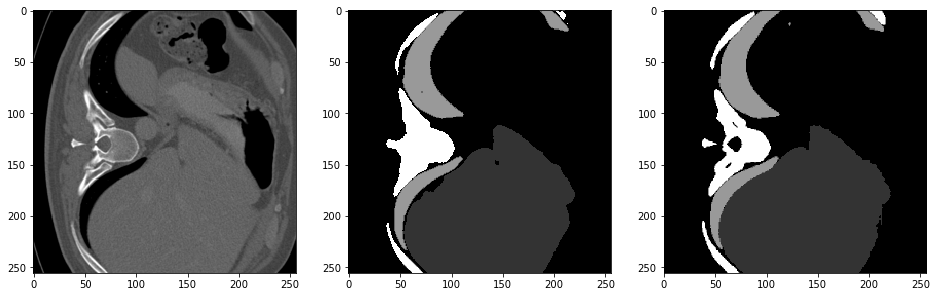

In [10]:
index = 50
run(index)
f, axarr = plt.subplots(1, 3, figsize=(16,12))

input_slice = np.load("images/" + original_images[index])
lbl_slice = np.load("labels/"+ original_images[index])
prediction = prepare_prediction(output_data[0])

axarr[0].imshow(input_slice[:, :], cmap = 'gray')
axarr[1].imshow(prediction[0,:,:], cmap = 'gray')
axarr[2].imshow(lbl_slice, cmap = 'gray')

f.savefig(f'inp-pred-true_{original_images[index]}.png', dpi=300)

In [ ]:
## Now performance :)

In [ ]:
def single_thread(start, end):
    [run(i) for i in range(start, end)]

In [ ]:
def measure_performances(threads=2):

    '''run threads '''
    print('Building',threads,'threads...')
    threadAll = []
    start=0
    for i in range(threads):
        if (i==threads-1):
            end = len(original_images)
        else:
            end = start+(len(original_images)//threads)
        t1 = threading.Thread(target=single_thread, args=(start, end))
        threadAll.append(t1)
        #  print(start, end)
        start=end

    print('Starting',threads,'threads...')
    with recorder.record(0.5):
        time1 = time.time()
        for x in threadAll:
            x.start()
        for x in threadAll:
            x.join()
        time2 = time.time()
        timetotal = time2 - time1

    fps = float(len(original_images) / timetotal)
    print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, len(original_images), timetotal))
    return fps, len(original_images), timetotal, np.mean(recorder.frame['12V_power'])

In [11]:
fpss = []
powers = []

for i in range(5):
    fps, _, _, power = measure_performances(threads=4)
    fpss.append(fps)
    powers.append(power)

print(fpss)
print(powers)
print("Throughput: %.2f +- %.2f with power consumption of %.2f +- %.2f" %(np.mean(fpss), np.std(fpss), np.mean(powers), np.std(powers)))

NameError: name 'measure_performances' is not defined

In [12]:
# Save output to evaluate performance
print("Saving predictions")
os.makedirs('predictions', exist_ok=True)

[run(i, save = True) for i in range(total_images)]

print('saved')


Saving predictions
saved


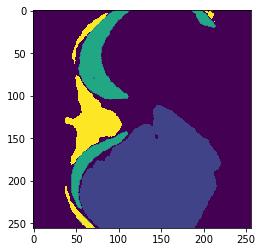

In [13]:
pred = np.load("predictions/" + original_images[index])
_, ax = plt.subplots(1)
_ = ax.imshow(prediction[0,:,:])

In [ ]:
del overlay
del dpu